# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these. This project analyses the results of an A/B test run by an e-commerce website. The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability
To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#Setting the seed to assure getting the same answers on quizzes as setup here
random.seed(42)

`1.` Read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset.

There are **294478 rows** in this dataset.

In [3]:
df.shape[0]
#Alternatively
#len(df)

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.query('converted == 1')['user_id'].nunique() / df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
sum(df.query('group == "treatment"')['landing_page'] == 'old_page') + sum(df.query('group == "control"')['landing_page'] == 'new_page')

3893

f. Check if any of the rows have missing values.

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Create a new dataset that that does not contain rows with incorrect alignments. Store it in **df2**.

In [8]:
# remove the rows where the landing_page and group columns don't align, and save it in a new dataframe
new = df.query('landing_page == "new_page" and group == "treatment"')
old = df.query('landing_page == "old_page" and group == "control"')
df2 = pd.concat([new, old], axis = 0, ignore_index = True)

In [9]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below.

a. Find how many unique **user_id**s are in **df2**.

In [11]:
df2['user_id'].nunique()

290584

b. Find the **user_id** repeated in **df2**.

The repeated user_id is **773192**.

In [12]:
df2.user_id.loc[df2.user_id.duplicated()]

1404    773192
Name: user_id, dtype: int64

c. The row information for the repeat **user_id 773192**

In [13]:
df2.loc[df2['user_id'] == 773192]
# Alternatively
# df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, keeping the dataframe as **df2**.

In [14]:
df2 = df2.drop(1404)

`4.` Use **df2** in the below cells.

a. The probability of an individual converting regardless of the page they receive.

In [15]:
df2['converted'].mean()
#Alternatively
#df2.converted.mean()

0.11959708724499628

b. The probability an individual converted, given that s/he was in the `control` group.

In [16]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. The probability an individual converted, given that s/he was in the `treatment` group.

In [17]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. The probability that an individual received the new page.

In [18]:
df2.query('landing_page == "new_page"')['user_id'].count() / df2['user_id'].count()

0.50006194422266881

e. Suggesting if there is evidence that one page leads to more conversions, using the previous results.

**There isn't enough evidence to say if either of the old and new  pages lead to more conversions.**

**The converted rate of the old page (control group) is 12.0% (0.1203863045)**

**The converted rate of the new page (treatment group) is 11.9 (0.118837507056)**

**The difference in converted rate is less than 0.1% (0.00154879744), which is very small.**

**Hence, inferential statistics should be used to get more evidence.**

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, we can technically run a hypothesis test continuously as each observation was observed. However, then the hard question is do we stop as soon as one page is considered significantly better than another, or does it need to happen consistently for a certain amount of time? How long do we run to render a decision that neither page is better than another? These questions are the difficult parts associated with A/B tests in general.  

`1.` Considering we need to make the decision just based on all the data provided. If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypotheses are as follows.

**$H_{0}:  p_{new} - p_{old} \leq 0$**

**The old landing page has the same or even higher converted rate than the new page.**


**$H_{1}:  p_{new} - p_{old} > 0$**

**The old landing page has lower converted rate than the new page.**

`2.` Assuming that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>

Using a sample size for each page equal to the ones in **ab_data.csv**. A sampling distribution is performend for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null. The below cells provide the necessary parts of this simulation.

a. The **convert rate** for $p_{new}$ under the null.

In [19]:
p_new = df2['converted'].mean()

In [20]:
p_new

0.11959708724499628

b. The **convert rate** for $p_{old}$ under the null.

In [21]:
p_old = df2['converted'].mean()

In [22]:
p_old

0.11959708724499628

c. $n_{new}$

In [23]:
n_new = df2.query('landing_page == "new_page"')['user_id'].count()

In [24]:
n_new

145310

d. $n_{old}$

In [25]:
n_old = df2.query('landing_page == "old_page"')['user_id'].count()

In [26]:
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = np.random.choice([0, 1], size = n_new, p = [(1 - p_new), p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.choice([0, 1], size = n_old, p = [(1 - p_old), p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
new_page_converted.mean() - old_page_converted.mean()

-0.00029110831018093475

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one calculated in parts **a. through g.** above. Store all 10,000 values in **p_diffs**.

In [30]:
p_diffs = []

# Rerun the simulation 10000 times
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size = n_new, p = [(1 - p_new), p_new])
    old_page_converted = np.random.choice([0, 1], size = n_old, p = [(1 - p_old), p_old])
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.

Text(0,0.5,'Frequency')

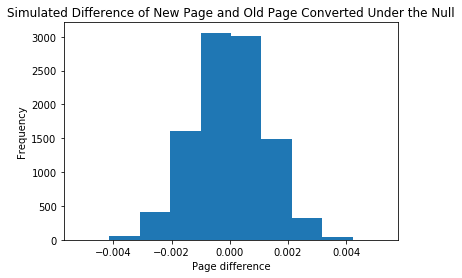

In [31]:
plt.hist(p_diffs)
plt.title('Simulated Difference of New Page and Old Page Converted Under the Null')
plt.xlabel('Page difference')
plt.ylabel('Frequency')

The simulated data creates a normal distribution, where the mean is 0.

j. The proportion of the **p_diffs** greater than the actual difference observed in **ab_data.csv**.

In [32]:
actual_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
actual_diff

-0.0015782389853555567

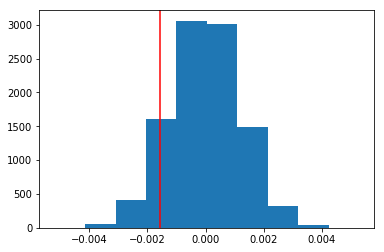

In [33]:
plt.hist(p_diffs)
plt.axvline(actual_diff, color = 'r');

In [34]:
p_diffs = np.array(p_diffs)
p_val = (p_diffs > actual_diff).mean()
p_val

0.9042

k. Explaination of what was computed in part **j.**.  What is this value called in scientific studies? What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value calculated  is the p-value. It is the probability of getting the observed data or more extreme values given that the null hypothesis is true. A large p-value suggests to not move away from the null hypothesis. Since the calculated p-value is 0.90, which is a large number between 0 and 1, we should retain the null hypothesis, that is, the new page does not do significantly better than the old page.**

l. A built-in could also be used to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. The below cells calculate the number of conversions for each page, as well as the number of individuals who received each page. `n_old` and `n_new` refer to the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"').query('converted == 1')['user_id'].count()
convert_new = df2.query('landing_page == "new_page"').query('converted == 1')['user_id'].count()
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_new = df2.query('landing_page == "new_page"')['user_id'].count()

print("convert_old:", convert_old, "\nconvert_new:", convert_new, "\nn_old:", n_old, "\nn_new:", n_new)

/Users/Bayan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


convert_old: 17489 
convert_new: 17264 
n_old: 145274 
n_new: 145310


m. Use `stats.proportions_ztest` to compute the test statistic and p-value.

[Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
print("z-score:", z_score,
     "\np-value:", p_value)

z-score: 1.31092419842 
p-value: 0.905058312759


In [37]:
'''from scipy.stats import norm
norm.ppf(1-(0.05))'''

'from scipy.stats import norm\nnorm.ppf(1-(0.05))'

n. Explaination of what the z-score and p-value previously computed in mean for the conversion rates of the old and new pages, and whether or not they agree with the findings in parts **j.** and **k.**.

**The calculated z-score is around 1.31, and the p-value is around 0.90. Since this z-score is less than the critical z-score of 1.64, we fail to reject the null. The p-score is very close to what we got in parts j. and k., which is around 0.904. All the findings in this part agree with the findings in parts j. and k. As the result, we should retain the null hypothesis, which is that there is no difference between the conversion rates of the old and new pages.**

<a id='regression'></a>
### Part III - A regression approach

`1.` Exploring if the result acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, the following type of regression should be performed.

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, first we need to create a column for the intercept, and create a dummy variable column for which page each user received. Thus, an **intercept** column, as well as an **ab_page** column were added. The latter is 1 when an individual receives the **treatment** and 0 if **control**.

In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [39]:
df2['intercept'] = 1
df2[['drop', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop('drop', axis = 1, inplace = True)

In [40]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Using **statsmodels** to import the regression model.  Instantiate the model, and fit the model using the two columns created in part **b.** to predict whether or not an individual converts.

In [41]:
# Logistic Regression
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
result = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. The summary of the model.

In [42]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 02 Feb 2019   Pseudo R-squ.:               8.077e-06
Time:                        23:11:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. Explaination of why the p-value is associated with **ab_page**, and why it differs from the value found in the **Part II**. Furthermore, what the null and alternative hypotheses associated with the regression model are, and how they compare to the null and alternative hypotheses in the **Part II**.

**The p-value associated with `ab_page` is 0.19, which is lower than the p-value calculated using the built-in z-test method above. The reason why the value is lower is because an intercept was added.**

**The null hypothesis in Part II states that the new page leads to equal or lower conversion rate than the old, and the alternative hypothesis states that the new page leads to higher conversion rate than the old.**

**The hypotheses associated with the logistic regression are as follows;

$H_{0}$ : $p_{new}$ - $p_{old}$ = 0

**The new page leads to the same conversion rate as the old page.**

$H_{1}$ : $p_{new}$ - $p_{old}$ != 0

**The new page leads to a different conversion rate than the old page.**

f. Considering other things that might influence whether or not an individual converts. Discussing why it is a good idea to consider other factors to add into the regression model, and whether there any disadvantages to adding additional terms into the regression model.

**There might be some disadvantages to adding too many features into the analysis that only happen to have small impact. Carefully picking what could be influencial could on the otherhand strengthen the analysis, and the findings from it.**

**For example, the analysis could benifit from introdicing other features like the duration the customer spent looking at a page as this could be a sign of preference where customers wouldn't bother spending much time on pages they cannot comprehend.**

g. Along with testing if the conversion rate changes for different pages, add an effect based on which country a user lives.

Read in the **countries.csv** dataset and merge together the datasets on the approporiate rows.
[Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Exploring if the country appears to have an impact on the conversion. Starting by creating a dummy variables for these country columns, and providing the statistical output.

In [43]:
# Importing country data
country_df = pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [44]:
# Merging the two datasets
complete_df = df2.merge(country_df, on = 'user_id', how = 'inner')
complete_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [45]:
complete_df = complete_df.join(pd.get_dummies(complete_df['country']))
complete_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [46]:
sm.Logit(complete_df['converted'], complete_df[['intercept', 'ab_page', 'US', 'UK']]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 02 Feb 2019   Pseudo R-squ.:               2.323e-05
Time:                        23:11:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

**Based on the results, there doesn't seem to be a statistically significant effect, and that the country doesn't affect on the conversion rate highly enough.**

h. We have looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there are significant effects on conversion by creating the necessary additional columns, fitting the new model, and providing the summary results and conclusions based on the results.

In [47]:
complete_df['group_country'] = complete_df['group'] + '_' + complete_df['country']
complete_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,group_country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,treatment_US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,treatment_US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0,treatment_CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,treatment_UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0,treatment_CA


In [48]:
complete_df = complete_df.join(pd.get_dummies(complete_df['group_country']))
complete_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,group_country,control_CA,control_UK,control_US,treatment_CA,treatment_UK,treatment_US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,treatment_US,0,0,0,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,treatment_US,0,0,0,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0,treatment_CA,0,0,0,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,treatment_UK,0,0,0,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0,treatment_CA,0,0,0,1,0,0


In [49]:
sm.Logit(complete_df['converted'], complete_df[['intercept', 'ab_page', 'US', 'UK', 'treatment_US', 'treatment_UK']]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 02 Feb 2019   Pseudo R-squ.:               3.482e-05
Time:                        23:19:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page         -0.0674      0.052     -1.297      0.195      -0.169       0.034
US               0.0175      0.038      0.465      0.642      -0.056       0.091
UK               0.0118      0.040      0.296      0.767      -0.066       0.090
treatment_US     0.0469      0.054      0.872      0.383      -0.059       0.152
treatment_UK     0.0783      0.057      1.378      0.168      -0.033       0.190
================================================================================
"""

**After adding everything together, it is clearly noticable that the p-values for all featues has increased. Thus, the landing page and country do not have a significant effect on the conversion rate.**